<a href="https://colab.research.google.com/github/root2116/direct-feedback-alignment/blob/main/dfa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 追実験1

In [ ]:
import locale
print(locale.getpreferredencoding())
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

ANSI_X3.4-1968


In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=55e089067bfd211500a5e4822ca66781155f6423fd329db82e0d0fa0a0a5fad0
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=fe229eb39864fdbbce48be55bd682b3c91ec1f5ea6824cd3f003433c37548e6f
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import cupy as np
import torch
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE


def softmax(x):
    # ベクトルxの各要素から最大値を引く（オーバーフロー防止のため）
    e_x = np.exp(x - np.max(x))
    # 要素ごとのexpの和で各要素を割り、確率として解釈できるようにする
    return e_x / e_x.sum(axis=0)

def sigmoid(x):
    return 1 / (1+ np.exp(-x))

def initialize_bp_params():
    np.random.seed(1)
    W1 = np.random.randn(400, 784) * 0.01
    b1 = np.zeros((400, 1))
    W2 = np.random.randn(400, 400) * 0.01
    b2 = np.zeros((400, 1))
    W3 = np.random.randn(400, 400) * 0.01
    b3 = np.zeros((400, 1))
    W4 = np.random.randn(10, 400) * 0.01
    b4 = np.zeros((10, 1))

    params = {  "W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2,
                "W3": W3,
                "b3": b3,
                "W4": W4,
                "b4": b4}

    return params

def initialize_dfa_params():
    np.random.seed(1)
    W1 = np.zeros((400, 784))
    b1 = np.zeros((400, 1))
    W2 = np.zeros((400, 400))
    b2 = np.zeros((400, 1))
    W3 = np.zeros((400, 400))
    b3 = np.zeros((400, 1))
    W4 = np.zeros((10, 400))
    b4 = np.zeros((10, 1))

    B1 = np.random.randn(400, 10) * 0.01
    B2 = np.random.randn(400, 10) * 0.01
    B3 = np.random.randn(400, 10) * 0.01

    params = {  "W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2,
                "W3": W3,
                "b3": b3,
                "W4": W4,
                "b4": b4,
                "B1": B1,
                "B2": B2,
                "B3": B3}

    return params

def forward_propagation(X, params):
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    W3 = params["W3"]
    b3 = params["b3"]
    W4 = params["W4"]
    b4 = params["b4"]

    A1 = np.dot(W1, X) + b1
    H1 = np.tanh(A1)
    A2 = np.dot(W2, H1) + b2
    H2 = np.tanh(A2)
    A3 = np.dot(W3, H2) + b3
    H3 = np.tanh(A3)
    AY = np.dot(W4, H3) + b4
    # Y_ = softmax(AY)
    Y_ = sigmoid(AY)

    cache = {"A1": A1,
            "H1": H1,
            "A2": A2,
            "H2": H2,
            "A3": A3,
            "H3": H3,
            "AY": AY,
            "Y_": Y_}

    return Y_, cache


def backward_propagation(params, cache, X, Y):
    # batch size
    N = X.shape[1]

    W1 = params["W1"]
    W2 = params["W2"]
    W3 = params["W3"]
    W4 = params["W4"]

    H1 = cache["H1"]
    H2 = cache["H2"]
    H3 = cache["H3"]
    Y_ = cache["Y_"]

    dY_ = (Y_ - Y)
    dW4 = (1 / N) * np.dot(dY_, H3.T)
    db4 = (1 / N) * np.sum(dY_, axis=1, keepdims=True)

    dH3 = np.dot(W4.T, dY_)
    dA3 = dH3 * (1 - np.power(H3, 2))
    dW3 = (1 / N) * np.dot(dA3, H2.T)
    db3 = (1 / N) * np.sum(dA3, axis=1, keepdims=True)

    dH2 = np.dot(W3.T, dA3)
    dA2 = dH2 * (1 - np.power(H2, 2))
    dW2 = (1 / N) * np.dot(dA2, H1.T)
    db2 = (1 / N) * np.sum(dA2, axis=1, keepdims=True)

    dH1 = np.dot(W2.T, dA2)
    dA1 = dH1 * (1 - np.power(H1, 2))
    dW1 = (1 / N) * np.dot(dA1, X.T)
    db1 = (1 / N) * np.sum(dA1, axis=1, keepdims=True)

    gradients = {"dW1": dW1,
                "db1": db1,
                "dW2": dW2,
                "db2": db2,
                "dW3": dW3,
                "db3": db3,
                "dW4": dW4,
                "db4": db4}

    return gradients

def direct_feedback_alignment(params, cache, X, Y):
    # batch size
    N = X.shape[1]

    B1 = params["B1"]
    B2 = params["B2"]
    B3 = params["B3"]

    H1 = cache["H1"]
    H2 = cache["H2"]
    H3 = cache["H3"]
    Y_ = cache["Y_"]

    dY_ = Y_ - Y
    dW4 = (1 / N) * np.dot(dY_, H3.T)
    db4 = (1 / N) * np.sum(dY_, axis=1, keepdims=True)

    dH3 = np.dot(B3, dY_)
    dA3 = dH3 * (1 - np.power(H3, 2))
    dW3 = (1 / N) * np.dot(dA3, H2.T)
    db3 = (1 / N) * np.sum(dA3, axis=1, keepdims=True)

    dH2 = np.dot(B2, dY_)
    dA2 = dH2 * (1 - np.power(H2, 2))
    dW2 = (1 / N) * np.dot(dA2, H1.T)
    db2 = (1 / N) * np.sum(dA2, axis=1, keepdims=True)

    dH1 = np.dot(B1, dY_)
    dA1 = dH1 * (1 - np.power(H1, 2))
    dW1 = (1 / N) * np.dot(dA1, X.T)
    db1 = (1 / N) * np.sum(dA1, axis=1, keepdims=True)

    gradients = {"dW1": dW1,
                "db1": db1,
                "dW2": dW2,
                "db2": db2,
                "dW3": dW3,
                "db3": db3,
                "dW4": dW4,
                "db4": db4}

    return gradients

def update_params(params, grads, learning_rate=0.01):
    params["W1"] -= learning_rate * grads["dW1"]
    params["b1"] -= learning_rate * grads["db1"]
    params["W2"] -= learning_rate * grads["dW2"]
    params["b2"] -= learning_rate * grads["db2"]
    params["W3"] -= learning_rate * grads["dW3"]
    params["b3"] -= learning_rate * grads["db3"]
    params["W4"] -= learning_rate * grads["dW4"]
    params["b4"] -= learning_rate * grads["db4"]
    return params


def compute_loss(Y_, Y):

    N = Y.shape[1]
    # loss = (-1 / N) * np.sum(np.multiply(Y, np.log(Y_)))
    loss = (-1 / N) * np.sum(np.multiply(Y, np.log(Y_)) + np.multiply(1 - Y, np.log(1 - Y_)))
    loss = np.squeeze(loss)

    return loss


def train(backward_propagation, params, train_loader, test_loader, learning_rate=0.01, num_epochs=100):
    train_error_list = []
    test_error_list = []

    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for i, (images, labels) in enumerate(train_loader):
            X = images.view(-1, 28 * 28)
            X = np.asarray(X).T
            Y = np.eye(10)[labels]
            Y = np.asarray(Y).T

            labels_gpu = np.asarray(labels)

            Y_, cache = forward_propagation(X, params)
            loss = compute_loss(Y_, Y)
            grads = backward_propagation(params, cache, X, Y)
            params = update_params(params, grads, learning_rate)

            total_loss += loss
            total_correct += np.sum(np.argmax(Y_, axis=0) == labels_gpu)
            total_samples += labels_gpu.shape[0]

            if i % 100 == 99:
                print('Epoch {}, iteration {}, loss : {}, accuracy : {}'.format(epoch+1, i+1, total_loss / 100, total_correct/ total_samples))
                total_loss = 0


        train_error_rate = (1 - (total_correct / total_samples)) * 100
        train_error_list.append(train_error_rate)

        total_loss = 0
        total_correct = 0
        total_samples = 0
        for i, (images, labels) in enumerate(test_loader):
            X = images.view(-1, 28 * 28)
            X = np.asarray(X).T
            Y = np.eye(10)[labels]
            Y = np.asarray(Y).T

            labels_gpu = np.asarray(labels)

            Y_, cache = forward_propagation(X, params)
            loss = compute_loss(Y_, Y)

            total_loss += loss
            total_correct += np.sum(np.argmax(Y_, axis=0) == labels_gpu)
            total_samples += labels_gpu.shape[0]

        test_error_rate = (1 - (total_correct / total_samples)) * 100
        test_error_list.append(test_error_rate)

        print('Test data - After epoch {}, loss : {}, accuracy : {}'.format(epoch+1, total_loss / len(test_loader), total_correct / total_samples))


    return params, train_error_list, test_error_list


def predict(X, params):
    Y_, cache = forward_propagation(X, params)
    predictions = np.argmax(Y_, axis=0)
    return predictions


def compute_accuracy(predictions, labels):
    return np.sum(predictions == labels) / len(labels)

def extract_features(params, loader):
    # Add a list for labels
    labels_list = []
    input_images = []
    first_hidden = []
    second_hidden = []
    third_hidden = []

    for images, labels in loader:
        X = images.view(-1, 28 * 28)
        X = np.asarray(X).T

        Y_, cache = forward_propagation(X, params)
        input_images.append(X.T)
        first_hidden.append(cache["H1"].T)
        second_hidden.append(cache["H2"].T)
        third_hidden.append(cache["H3"].T)
        # Save labels
        labels_list.append(np.asarray(labels))

    return (np.concatenate(input_images), np.concatenate(labels_list)), (np.concatenate(first_hidden), np.concatenate(labels_list)), \
           (np.concatenate(second_hidden), np.concatenate(labels_list)), (np.concatenate(third_hidden), np.concatenate(labels_list))


def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)

    fig = plt.figure(figsize=(6, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', marker='.', s=25)

    plt.grid(True)  # Add grid
    plt.xticks([])  # Remove x-ticks
    plt.yticks([])  # Remove y-ticks


    plt.show()





In [ ]:
if __name__=="__main__":
    batch_size = 64

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
    testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

    bp_params = initialize_bp_params()
    dfa_params = initialize_dfa_params()




100%|██████████| 9912422/9912422 [00:00<00:00, 206619212.12it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 104427322.26it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67663549.52it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3997173.47it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [ ]:
    print("Training with back propagation...")
    bp_params, bp_train_errors, bp_test_errors = train(backward_propagation, bp_params, train_loader, test_loader, learning_rate=0.01, num_epochs=50)

Training with back propagation...
Epoch 1, iteration 100, loss : 5.158494046803599, accuracy : 0.11453125
Epoch 1, iteration 200, loss : 3.2520343692403997, accuracy : 0.11171875
Epoch 1, iteration 300, loss : 3.2485251261177215, accuracy : 0.11322916666666667
Epoch 1, iteration 400, loss : 3.251783736201783, accuracy : 0.110546875
Epoch 1, iteration 500, loss : 3.249187049561885, accuracy : 0.11028125
Epoch 1, iteration 600, loss : 3.2485983703551, accuracy : 0.11059895833333333
Epoch 1, iteration 700, loss : 3.2500314195548605, accuracy : 0.10984375
Epoch 1, iteration 800, loss : 3.247741942279563, accuracy : 0.11048828125
Epoch 1, iteration 900, loss : 3.2488887424969324, accuracy : 0.11074652777777778
Test data - After epoch 1, loss : 3.2476177223091494, accuracy : 0.1135
Epoch 2, iteration 100, loss : 3.2444465930715336, accuracy : 0.1103125
Epoch 2, iteration 200, loss : 3.245835784406518, accuracy : 0.11296875
Epoch 2, iteration 300, loss : 3.2441695623881683, accuracy : 0.11442

In [ ]:
    print("Training with direct feedback alignment...")
    dfa_params, dfa_train_errors, dfa_test_errors = train(direct_feedback_alignment, dfa_params, train_loader, test_loader, learning_rate=0.01, num_epochs=50)

Training with direct feedback alignment...
Epoch 1, iteration 100, loss : 4.764254845804428, accuracy : 0.108125
Epoch 1, iteration 200, loss : 3.24990629906225, accuracy : 0.112265625
Epoch 1, iteration 300, loss : 3.2499011386148084, accuracy : 0.11109375
Epoch 1, iteration 400, loss : 3.2515852065902937, accuracy : 0.1109765625
Epoch 1, iteration 500, loss : 3.2510691339520226, accuracy : 0.11028125
Epoch 1, iteration 600, loss : 3.2515651623748325, accuracy : 0.10919270833333333
Epoch 1, iteration 700, loss : 3.250755823463967, accuracy : 0.10908482142857143
Epoch 1, iteration 800, loss : 3.250294649421692, accuracy : 0.109453125
Epoch 1, iteration 900, loss : 3.2370826331781637, accuracy : 0.11506944444444445
Test data - After epoch 1, loss : 3.193979838206953, accuracy : 0.2744
Epoch 2, iteration 100, loss : 3.1351961825025403, accuracy : 0.278125
Epoch 2, iteration 200, loss : 2.944784183172528, accuracy : 0.30828125
Epoch 2, iteration 300, loss : 2.686809538042885, accuracy : 0

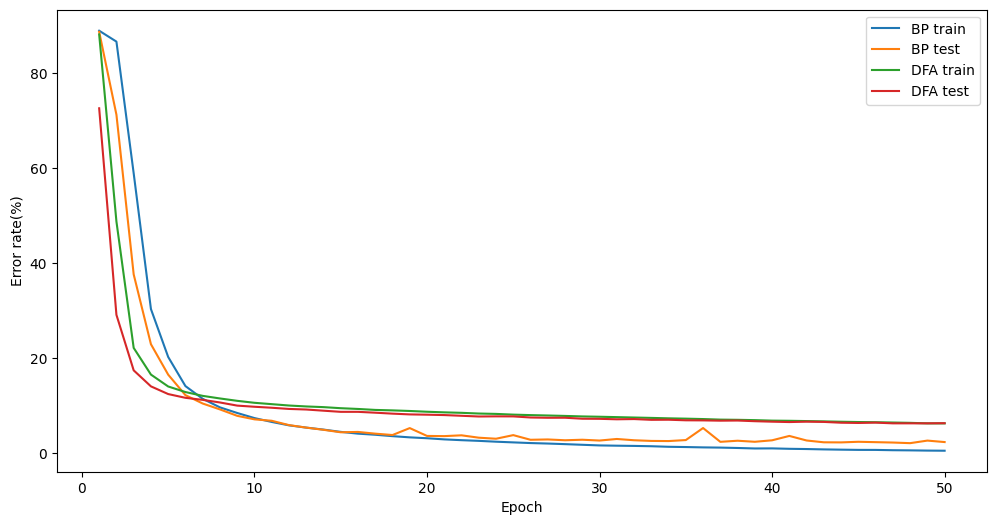

In [ ]:
    epochs = range(1, len(bp_train_errors) + 1)

    plt.figure(figsize=(12,6))
    plt.plot(epochs, [err.get() for err in bp_train_errors], label='BP train')
    plt.plot(epochs, [err.get() for err in bp_test_errors], label='BP test')
    plt.plot(epochs, [err.get() for err in dfa_train_errors], label='DFA train')
    plt.plot(epochs, [err.get() for err in dfa_test_errors], label='DFA test')
    plt.xlabel('Epoch')
    plt.ylabel('Error rate(%)')
    plt.legend()
    plt.show()

In [ ]:
import pickle

with open('bp_params.pkl', 'wb') as f:
    pickle.dump(bp_params, f)

with open('dfa_params.pkl', 'wb') as f:
    pickle.dump(dfa_params, f)

Extracting and plotting features for back propagation...


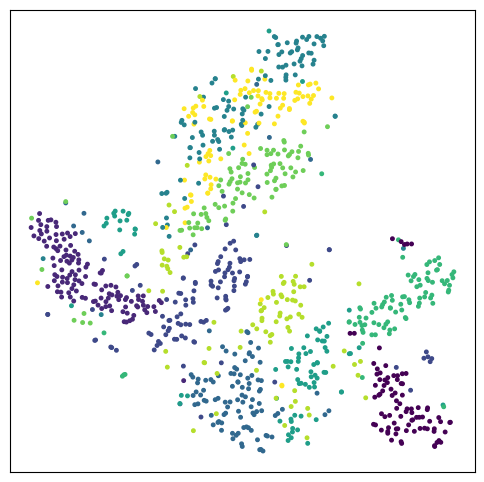

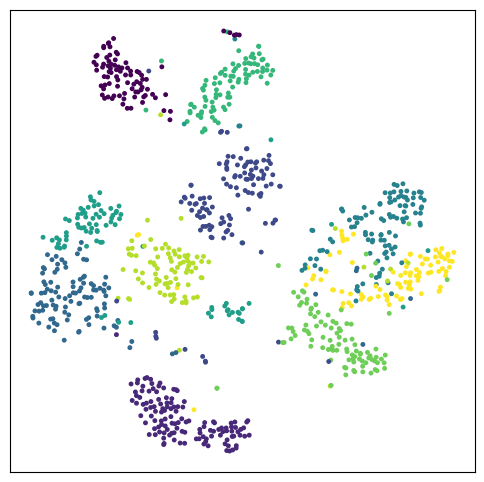

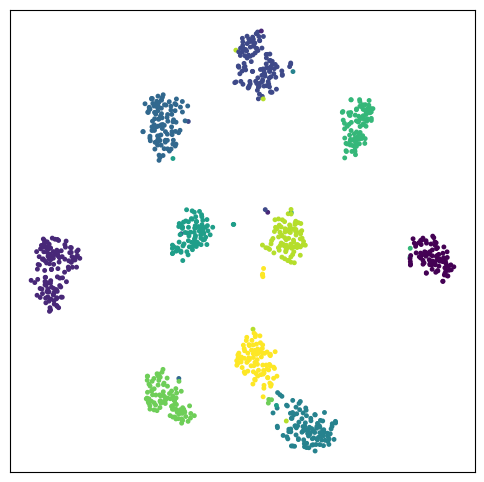

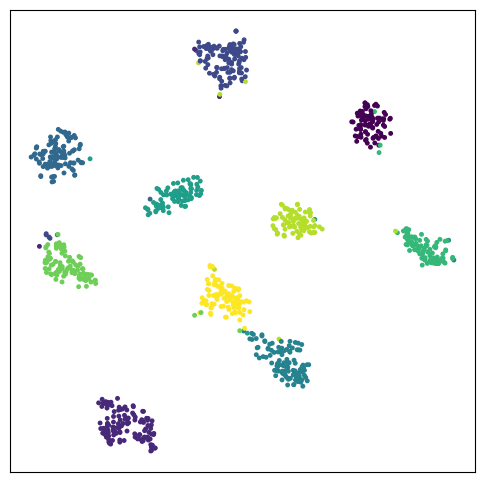

Extracting and plotting features for direct feedback alignment...


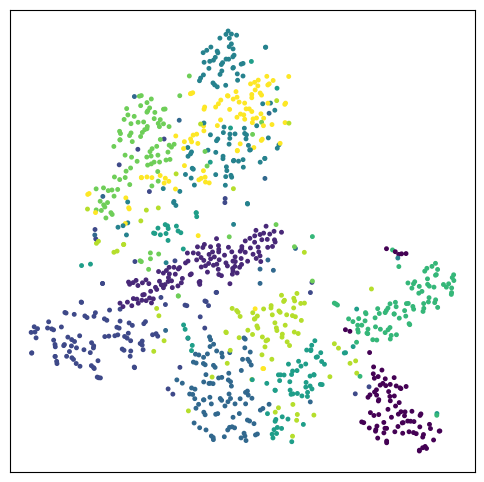

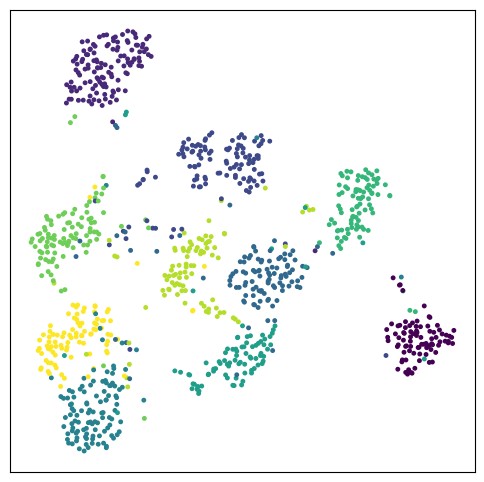

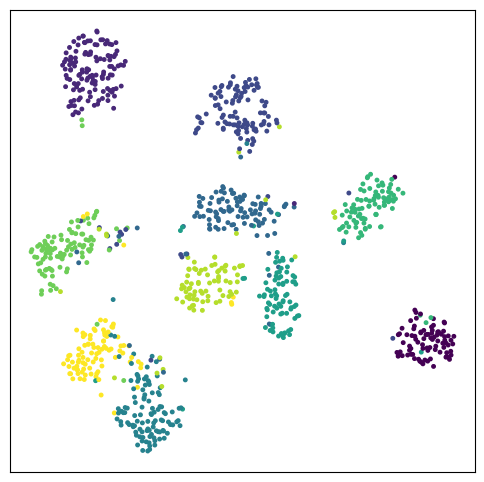

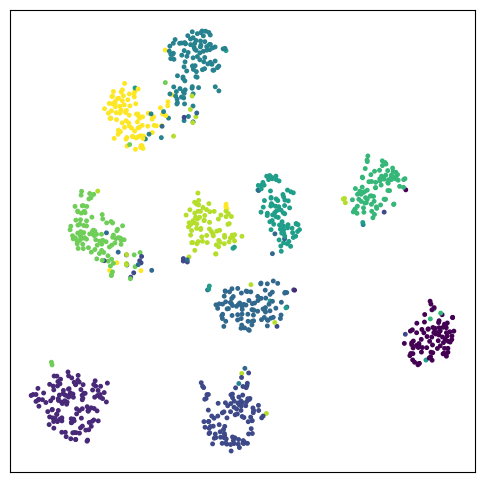

In [ ]:
    num_samples = 1000
    subset_indices = torch.arange(0, num_samples)
    subset_test_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(testset, subset_indices),
        batch_size=batch_size, shuffle=True)
    print("Extracting and plotting features for back propagation...")
    (bp_input_images, bp_input_labels), (bp_first_hidden, bp_first_labels), (bp_second_hidden, bp_second_labels), (bp_third_hidden, bp_third_labels) = extract_features(bp_params, subset_test_loader)
    plot_tsne(bp_input_images.get(), bp_input_labels.get())
    plot_tsne(bp_first_hidden.get(), bp_first_labels.get())
    plot_tsne(bp_second_hidden.get(), bp_second_labels.get())
    plot_tsne(bp_third_hidden.get(), bp_third_labels.get())

    print("Extracting and plotting features for direct feedback alignment...")
    (dfa_input_images, dfa_input_labels), (dfa_first_hidden, dfa_first_labels), (dfa_second_hidden, dfa_second_labels), (dfa_third_hidden, dfa_third_labels) = extract_features(dfa_params, subset_test_loader)
    plot_tsne(dfa_input_images.get(), dfa_input_labels.get())
    plot_tsne(dfa_first_hidden.get(), dfa_first_labels.get())
    plot_tsne(dfa_second_hidden.get(), dfa_second_labels.get())
    plot_tsne(dfa_third_hidden.get(), dfa_third_labels.get())

Extracting and plotting features for back propagation...
Extracting and plotting features for direct feedback alignment...


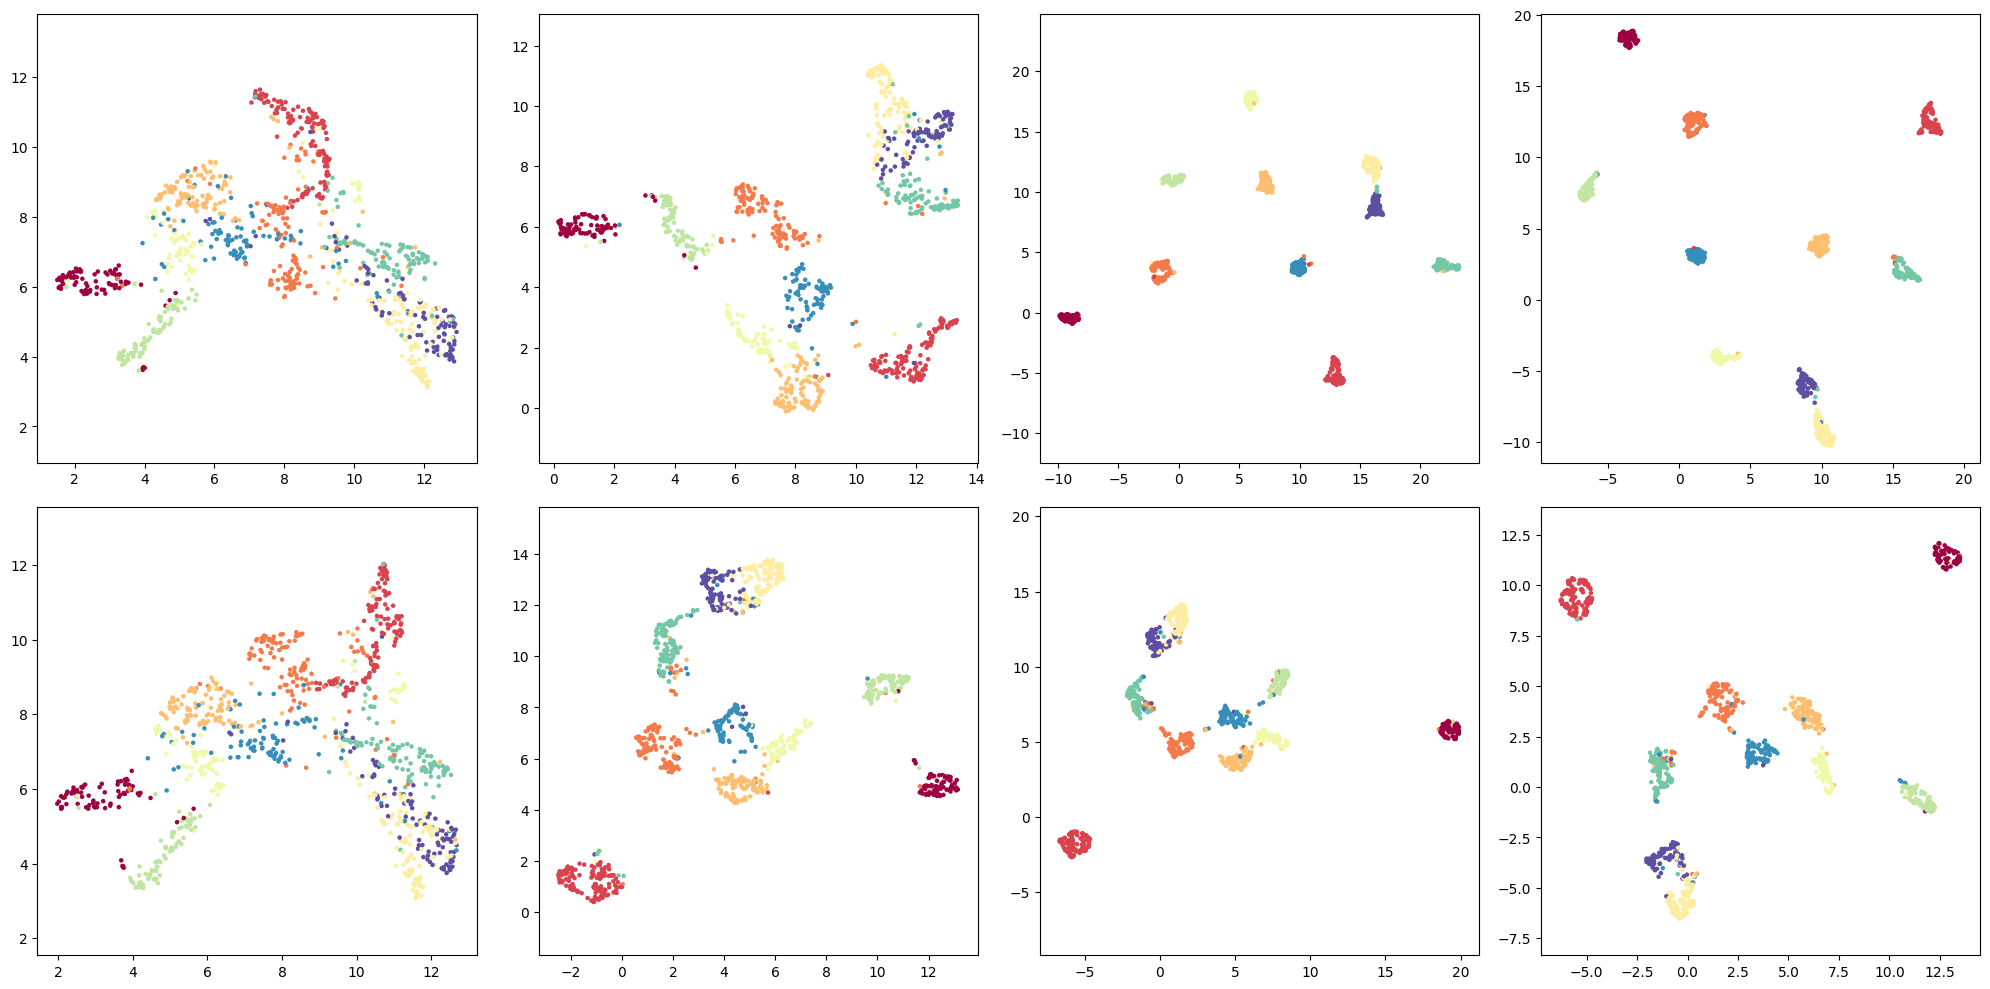

In [ ]:
import umap

def plot_umap_subplot(features, labels, ax):
    # Convert cupy arrays to numpy arrays using get method
    features = features.get()
    labels = labels.get()

    reducer = umap.UMAP()
    embedding = reducer.fit_transform(features)

    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=5)
    ax.set_aspect('equal', 'datalim')




    # Enable the outer frame
    for _, spine in ax.spines.items():
        spine.set_visible(True)

# define a function to generate the 2x4 grid of plots
def plot_grid(bp_features, dfa_features):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i in range(4):
        plot_umap_subplot(bp_features[i][0], bp_features[i][1], axs[0, i])
        plot_umap_subplot(dfa_features[i][0], dfa_features[i][1], axs[1, i])

    plt.tight_layout()
    plt.show()



if __name__=="__main__":
    num_samples = 1000
    subset_indices = torch.arange(0, num_samples)
    subset_test_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(testset, subset_indices),
        batch_size=batch_size, shuffle=True)

    print("Extracting and plotting features for back propagation...")
    bp_features = extract_features(bp_params, subset_test_loader)

    print("Extracting and plotting features for direct feedback alignment...")
    dfa_features = extract_features(dfa_params, subset_test_loader)

    # Call plot_grid function with the extracted features
    plot_grid(bp_features, dfa_features)

# 追実験2

In [ ]:
import cupy as np
import torch
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
import copy

def softmax(x):
    # ベクトルxの各要素から最大値を引く（オーバーフロー防止のため）
    e_x = np.exp(x - np.max(x))
    # 要素ごとのexpの和で各要素を割り、確率として解釈できるようにする
    return e_x / e_x.sum(axis=0)

def sigmoid(x):
    return 1 / (1+ np.exp(-x))

def initialize_bp_params():
    np.random.seed(1)
    W1 = np.random.randn(50, 784) * 0.01
    b1 = np.zeros((50, 1))
    W2 = np.random.randn(50, 50) * 0.01
    b2 = np.zeros((50, 1))
    W3 = np.random.randn(50, 50) * 0.01
    b3 = np.zeros((50, 1))
    W4 = np.random.randn(10, 50) * 0.01
    b4 = np.zeros((10, 1))

    params = {  "W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2,
                "W3": W3,
                "b3": b3,
                "W4": W4,
                "b4": b4}

    return params

def initialize_dfa_params():
    np.random.seed(1)
    W1 = np.zeros((50, 784))
    b1 = np.zeros((50, 1))
    W2 = np.zeros((50, 50))
    b2 = np.zeros((50, 1))
    W3 = np.zeros((50, 50))
    b3 = np.zeros((50, 1))
    W4 = np.zeros((10, 50))
    b4 = np.zeros((10, 1))

    B1 = np.random.randn(50, 10) * 0.01
    B2 = np.random.randn(50, 10) * 0.01
    B3 = np.random.randn(50, 10) * 0.01

    params = {  "W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2,
                "W3": W3,
                "b3": b3,
                "W4": W4,
                "b4": b4,
                "B1": B1,
                "B2": B2,
                "B3": B3}

    return params

def forward_propagation(X, params):
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    W3 = params["W3"]
    b3 = params["b3"]
    W4 = params["W4"]
    b4 = params["b4"]

    A1 = np.dot(W1, X) + b1
    H1 = np.tanh(A1)
    A2 = np.dot(W2, H1) + b2
    H2 = np.tanh(A2)
    A3 = np.dot(W3, H2) + b3
    H3 = np.tanh(A3)
    AY = np.dot(W4, H3) + b4
    # Y_ = softmax(AY)
    Y_ = sigmoid(AY)

    cache = {"A1": A1,
            "H1": H1,
            "A2": A2,
            "H2": H2,
            "A3": A3,
            "H3": H3,
            "AY": AY,
            "Y_": Y_}

    return Y_, cache

def backward_propagation(params, cache, X, Y):
    # batch size
    N = X.shape[1]

    W1 = params["W1"]
    W2 = params["W2"]
    W3 = params["W3"]
    W4 = params["W4"]

    H1 = cache["H1"]
    H2 = cache["H2"]
    H3 = cache["H3"]
    Y_ = cache["Y_"]

    dY_ = (Y_ - Y)
    dW4 = (1 / N) * np.dot(dY_, H3.T)
    db4 = (1 / N) * np.sum(dY_, axis=1, keepdims=True)

    dH3 = np.dot(W4.T, dY_)
    dA3 = dH3 * (1 - np.power(H3, 2))
    dW3 = (1 / N) * np.dot(dA3, H2.T)
    db3 = (1 / N) * np.sum(dA3, axis=1, keepdims=True)

    dH2 = np.dot(W3.T, dA3)
    dA2 = dH2 * (1 - np.power(H2, 2))
    dW2 = (1 / N) * np.dot(dA2, H1.T)
    db2 = (1 / N) * np.sum(dA2, axis=1, keepdims=True)

    dH1 = np.dot(W2.T, dA2)
    dA1 = dH1 * (1 - np.power(H1, 2))
    dW1 = (1 / N) * np.dot(dA1, X.T)
    db1 = (1 / N) * np.sum(dA1, axis=1, keepdims=True)

    gradients = {"dW1": dW1,
                "db1": db1,
                "dW2": dW2,
                "db2": db2,
                "dW3": dW3,
                "db3": db3,
                "dW4": dW4,
                "db4": db4}

    return gradients

def direct_feedback_alignment(params, cache, X, Y):
    # batch size
    N = X.shape[1]

    B1 = params["B1"]
    B2 = params["B2"]
    B3 = params["B3"]

    H1 = cache["H1"]
    H2 = cache["H2"]
    H3 = cache["H3"]
    Y_ = cache["Y_"]

    dY_ = Y_ - Y
    dW4 = (1 / N) * np.dot(dY_, H3.T)
    db4 = (1 / N) * np.sum(dY_, axis=1, keepdims=True)

    dH3 = np.dot(B3, dY_)
    dA3 = dH3 * (1 - np.power(H3, 2))
    dW3 = (1 / N) * np.dot(dA3, H2.T)
    db3 = (1 / N) * np.sum(dA3, axis=1, keepdims=True)

    dH2 = np.dot(B2, dY_)
    dA2 = dH2 * (1 - np.power(H2, 2))
    dW2 = (1 / N) * np.dot(dA2, H1.T)
    db2 = (1 / N) * np.sum(dA2, axis=1, keepdims=True)

    dH1 = np.dot(B1, dY_)
    dA1 = dH1 * (1 - np.power(H1, 2))
    dW1 = (1 / N) * np.dot(dA1, X.T)
    db1 = (1 / N) * np.sum(dA1, axis=1, keepdims=True)

    gradients = {"dW1": dW1,
                "db1": db1,
                "dW2": dW2,
                "db2": db2,
                "dW3": dW3,
                "db3": db3,
                "dW4": dW4,
                "db4": db4}

    return gradients


def update_params(params, grads, learning_rate=0.01, is_weights_fixed=False):
    if not is_weights_fixed:
        params["W1"] -= learning_rate * grads["dW1"]
        params["b1"] -= learning_rate * grads["db1"]
    params["W2"] -= learning_rate * grads["dW2"]
    params["b2"] -= learning_rate * grads["db2"]
    params["W3"] -= learning_rate * grads["dW3"]
    params["b3"] -= learning_rate * grads["db3"]
    params["W4"] -= learning_rate * grads["dW4"]
    params["b4"] -= learning_rate * grads["db4"]
    return params


def compute_loss(Y_, Y):

    N = Y.shape[1]
    # loss = (-1 / N) * np.sum(np.multiply(Y, np.log(Y_)))
    loss = (-1 / N) * np.sum(np.multiply(Y, np.log(Y_)) + np.multiply(1 - Y, np.log(1 - Y_)))
    loss = np.squeeze(loss)

    return loss


def train(backward_propagation, params, train_loader, test_loader, train_error_list, test_error_list, learning_rate=0.01, start_epoch=0, num_epochs=50, is_weights_fixed=False):
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for i, (images, labels) in enumerate(train_loader):
            X = images.view(-1, 28 * 28)
            X = np.asarray(X).T
            Y = np.eye(10)[labels]
            Y = np.asarray(Y).T

            labels_gpu = np.asarray(labels)

            Y_, cache = forward_propagation(X, params)
            loss = compute_loss(Y_, Y)
            grads = backward_propagation(params, cache, X, Y)
            params = update_params(params, grads, learning_rate, is_weights_fixed=is_weights_fixed)

            total_loss += loss
            total_correct += np.sum(np.argmax(Y_, axis=0) == labels_gpu)
            total_samples += labels_gpu.shape[0]

            if i % 100 == 99:
                print('Epoch {}, iteration {}, loss : {}, accuracy : {}'.format(start_epoch+epoch+1, i+1, total_loss / 100, total_correct/ total_samples))
                total_loss = 0


        train_error_rate = (1 - (total_correct / total_samples)) * 100
        train_error_list.append(train_error_rate)

        total_loss = 0
        total_correct = 0
        total_samples = 0
        for i, (images, labels) in enumerate(test_loader):
            X = images.view(-1, 28 * 28)
            X = np.asarray(X).T
            Y = np.eye(10)[labels]
            Y = np.asarray(Y).T

            labels_gpu = np.asarray(labels)

            Y_, cache = forward_propagation(X, params)
            loss = compute_loss(Y_, Y)

            total_loss += loss
            total_correct += np.sum(np.argmax(Y_, axis=0) == labels_gpu)
            total_samples += labels_gpu.shape[0]

        test_error_rate = (1 - (total_correct / total_samples)) * 100
        test_error_list.append(test_error_rate)

        print('Test data - After epoch {}, loss : {}, accuracy : {}'.format(start_epoch+epoch+1, total_loss / len(test_loader), total_correct / total_samples))

    return params, train_error_list, test_error_list



def predict(X, params):
    Y_, cache = forward_propagation(X, params)
    predictions = np.argmax(Y_, axis=0)
    return predictions


def compute_accuracy(predictions, labels):
    return np.sum(predictions == labels) / len(labels)

In [ ]:
if __name__=='__main__':
    batch_size = 64

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
    testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

    params = initialize_bp_params()


100%|██████████| 9912422/9912422 [00:00<00:00, 153328211.70it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112579641.10it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 63531310.48it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23204054.53it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [ ]:
    bp_train_error_list = []
    bp_test_error_list = []
    dfa_train_error_list = []
    dfa_test_error_list = []

    print("Training the first 50 epochs with back propagation...")
    params, bp_train_error_list, bp_test_error_list = train(backward_propagation,
                                                            params,
                                                            train_loader,
                                                            test_loader,
                                                            bp_train_error_list,
                                                            bp_test_error_list,
                                                            learning_rate=0.01,
                                                            num_epochs=50,
                                                            is_weights_fixed=True)




Training the first 50 epochs with back propagation...
Epoch 1, iteration 100, loss : 6.251203061294154, accuracy : 0.11015625
Epoch 1, iteration 200, loss : 5.233719176336223, accuracy : 0.109140625
Epoch 1, iteration 300, loss : 4.556287088764117, accuracy : 0.11239583333333333
Epoch 1, iteration 400, loss : 4.045634576286473, accuracy : 0.112578125
Epoch 1, iteration 500, loss : 3.6443153644882016, accuracy : 0.11209375
Epoch 1, iteration 600, loss : 3.3873677112249028, accuracy : 0.112265625
Epoch 1, iteration 700, loss : 3.28170039171592, accuracy : 0.11285714285714285
Epoch 1, iteration 800, loss : 3.2562153992941667, accuracy : 0.11216796875
Epoch 1, iteration 900, loss : 3.251094146945063, accuracy : 0.11203125
Test data - After epoch 1, loss : 3.2493919844640833, accuracy : 0.1135
Epoch 2, iteration 100, loss : 3.2479958785365994, accuracy : 0.1215625
Epoch 2, iteration 200, loss : 3.250129591402689, accuracy : 0.114140625
Epoch 2, iteration 300, loss : 3.2498514826844405, accu

In [ ]:
import pickle

with open('bp_params_50.pkl', 'wb') as f:
    pickle.dump(params, f)



In [ ]:
    bp_params = copy.deepcopy(params)
    dfa_params = copy.deepcopy(params)
    dfa_train_error_list = copy.deepcopy(bp_train_error_list)
    dfa_test_error_list = copy.deepcopy(bp_test_error_list)

In [ ]:
    print("Training the last 50 epochs with back propagation...")
    bp_params, bp_train_error_list, bp_test_error_list = train(backward_propagation,
                                                            bp_params,
                                                            train_loader,
                                                            test_loader,
                                                            bp_train_error_list,
                                                            bp_test_error_list,
                                                            learning_rate=0.01,
                                                            start_epoch=50,
                                                            num_epochs=50,
                                                            is_weights_fixed=False)

Training the last 50 epochs with back propagation...
Epoch 51, iteration 100, loss : 4.055828144861296, accuracy : 0.39640625
Epoch 51, iteration 200, loss : 1.3052256329883454, accuracy : 0.577890625
Epoch 51, iteration 300, loss : 1.060704896215039, accuracy : 0.6589583333333333
Epoch 51, iteration 400, loss : 0.9810037056295065, accuracy : 0.70328125
Epoch 51, iteration 500, loss : 0.8992405895198027, accuracy : 0.73340625
Epoch 51, iteration 600, loss : 0.829956117629691, accuracy : 0.7569010416666667
Epoch 51, iteration 700, loss : 0.7611765932883092, accuracy : 0.7746875
Epoch 51, iteration 800, loss : 0.7298127563935191, accuracy : 0.78841796875
Epoch 51, iteration 900, loss : 0.6699334703774303, accuracy : 0.80109375
Test data - After epoch 51, loss : 0.6548019835768262, accuracy : 0.9023
Epoch 52, iteration 100, loss : 0.6614351589706081, accuracy : 0.900625
Epoch 52, iteration 200, loss : 0.638741205266274, accuracy : 0.90375
Epoch 52, iteration 300, loss : 0.6365222440816488

In [ ]:
with open('bp_params_100.pkl', 'wb') as f:
    pickle.dump(bp_params, f)

In [ ]:
    dfa_params["B1"] = np.random.randn(50, 10) * 0.01
    dfa_params["B2"] = np.random.randn(50, 10) * 0.01
    dfa_params["B3"] = np.random.randn(50, 10) * 0.01
    print("Training the last 50 epochs with direct feedback alignment...")
    dfa_params, dfa_train_error_list, dfa_test_error_list = train(direct_feedback_alignment,
                                                            dfa_params,
                                                            train_loader,
                                                            test_loader,
                                                            dfa_train_error_list,
                                                            dfa_test_error_list,
                                                            learning_rate=0.01,
                                                            start_epoch=50,
                                                            num_epochs=50,
                                                            is_weights_fixed=False)

Training the last 50 epochs with direct feedback alignment...
Epoch 51, iteration 100, loss : 1.3881059419927582, accuracy : 0.73453125
Epoch 51, iteration 200, loss : 1.4686694434784977, accuracy : 0.724140625
Epoch 51, iteration 300, loss : 1.504530741679283, accuracy : 0.7150520833333334
Epoch 51, iteration 400, loss : 1.5493549259979076, accuracy : 0.709921875
Epoch 51, iteration 500, loss : 1.638415053508466, accuracy : 0.70140625
Epoch 51, iteration 600, loss : 1.7392104567602777, accuracy : 0.6911197916666667
Epoch 51, iteration 700, loss : 1.8700841739101284, accuracy : 0.6784598214285714
Epoch 51, iteration 800, loss : 1.9581231911039954, accuracy : 0.66564453125
Epoch 51, iteration 900, loss : 2.040671009097808, accuracy : 0.6526909722222223
Test data - After epoch 51, loss : 2.028265763807668, accuracy : 0.5669
Epoch 52, iteration 100, loss : 2.1211220992102175, accuracy : 0.5284375
Epoch 52, iteration 200, loss : 2.18425006736325, accuracy : 0.525390625
Epoch 52, iteration 

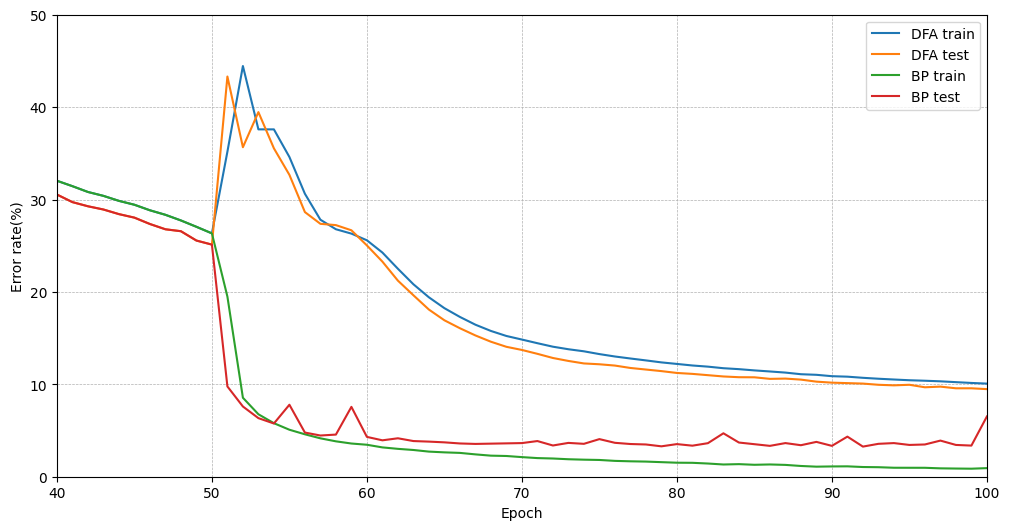

In [ ]:
    epochs = range(1, len(bp_train_error_list) + 1)

    plt.figure(figsize=(12,6))
    plt.plot(epochs, [err.get() for err in dfa_train_error_list], label='DFA train')
    plt.plot(epochs, [err.get() for err in dfa_test_error_list], label='DFA test')
    plt.plot(epochs, [err.get() for err in bp_train_error_list], label='BP train')
    plt.plot(epochs, [err.get() for err in bp_test_error_list], label='BP test')

    plt.xlabel('Epoch')
    plt.ylabel('Error rate(%)')

    plt.xlim(40, max(epochs))  # limit x-axis from epoch 40
    plt.ylim(0, 50)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()